# Quantum Approximate Optimization Algorithm with Sampler primitive

## Overview

Quantum Approximate Optimization Algorithm (QAOA) is a well-known algorithm for finding approximate solutions to combinatorial-optimization problems. It is a variational algorithm, meaning that it starts with a random guess and then iteratively improves the guess using a feedback loop between a quantum computer and a classical computer.

This tutorial demonstrates using QAOA for a graph partition problem with the `Sampler` Qiskit Runtime primitive.


## Set up your local development environment

This tutorial requires a Qiskit Runtime service instance. If you haven’t done so already, follow [these steps](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html) to set one up.

## Generate graph

First we will define an adjacency matrix to represent the graph we want to study. We will use `rustworkx` to visualize the graph. 

In [1]:
import numpy as np

num_nodes = 4
w = np.array(
    [
        [0.0, 1.0, 1.0, 0.0],
        [1.0, 0.0, 1.0, 1.0],
        [1.0, 1.0, 0.0, 1.0],
        [0.0, 1.0, 1.0, 0.0],
    ]
)

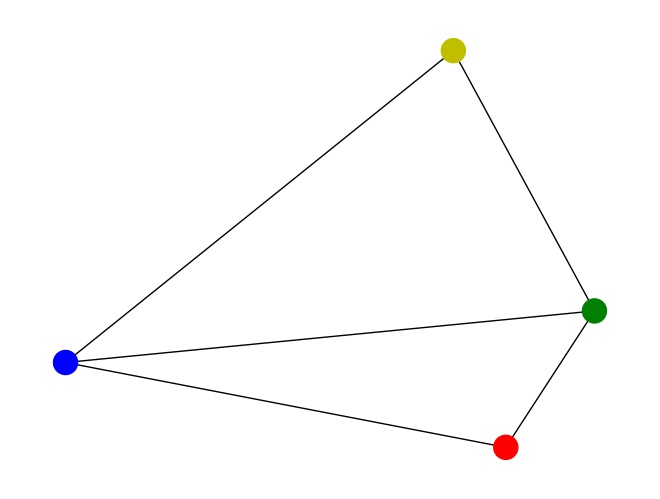

In [2]:
import rustworkx
from rustworkx.visualization import mpl_draw

graph = rustworkx.PyGraph.from_adjacency_matrix(w)
layout = rustworkx.random_layout(graph, seed=50)
colors = ["r", "g", "b", "y"]
mpl_draw(graph, layout, node_color=colors)

## Convert graph to a Hamiltonian


The graph partition problem can be converted to an Ising Hamiltonian. Qiskit has different capabilities in the Optimization module to perform this. Here, since the goal is to show QAOA with `Sampler`, the module is used without further explanation to create the operator. The paper [Ising formulations of many NP problems](https://arxiv.org/abs/1302.5843) may be of interest if you would like to understand the technique further.

In [3]:
from qiskit.quantum_info import Pauli, SparsePauliOp


def get_operator(weight_matrix: np.ndarray) -> tuple[SparsePauliOp, float]:
    r"""Generate Hamiltonian for the graph partitioning
    Notes:
        Goals:
            1 Separate the vertices into two set of the same size.
            2 Make sure the number of edges between the two set is minimized.
        Hamiltonian:
            H = H_A + H_B
            H_A = sum\_{(i,j)\in E}{(1-ZiZj)/2}
            H_B = (sum_{i}{Zi})^2 = sum_{i}{Zi^2}+sum_{i!=j}{ZiZj}
            H_A is for achieving goal 2 and H_B is for achieving goal 1.
    Args:
        weight_matrix: Adjacency matrix.
    Returns:
        Operator for the Hamiltonian
        A constant shift for the obj function.
    """
    num_nodes = len(weight_matrix)
    pauli_list = []
    coeffs = []
    shift = 0

    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(-0.5)
                shift += 0.5

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(1.0)
            else:
                shift += 1

    return SparsePauliOp(pauli_list, coeffs=coeffs), shift


qubit_op, offset = get_operator(w)

## Initialize service and select a backend

Next, we will create a service instance and specify a backend. In this example we will use a simulator to avoid queue times, but you can use the following code to run on a real device by simply changing the backend. Note that you will need to specify account credentials if they were not previously saved on disk.

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = "ibmq_qasm_simulator"

## Run QAOA algorithm

Finally, we will use the QAOA algorithm to find a balanced partition with the least number of crossing edges. We will pass the Qiskit Runtime `Sampler` primitive and COBYLA optimizer to the algorithm. Since QAOA is a variational algorithm, we will also run it inside a [session](https://qiskit.org/ecosystem/ibm-runtime/sessions.html) to minimize delays between each iteration.

In [7]:
from typing import Union

from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.quantum_info import Statevector
from qiskit.result import QuasiDistribution
from qiskit.utils import algorithm_globals

from qiskit_ibm_runtime import Sampler, Session


def objective_value(x: np.ndarray, w: np.ndarray) -> float:
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array.
        w: Adjacency matrix.
    Returns:
        Value of the cut.
    """
    X = np.outer(x, (1 - x))
    w_01 = np.where(w != 0, 1, 0)
    return np.sum(w_01 * X)


def bitfield(n: int, L: int) -> list[int]:
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part


def sample_most_likely(
    state_vector: Union[QuasiDistribution, Statevector]
) -> np.ndarray:
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)


algorithm_globals.random_seed = 10598
optimizer = COBYLA()

with Session(service=service, backend=backend):
    sampler = Sampler()
    qaoa = QAOA(sampler, optimizer, reps=2)
    result = qaoa.compute_minimum_eigenvalue(qubit_op)
    x = sample_most_likely(result.eigenstate)

print(f"Objective value computed by QAOA is {objective_value(x, w)}")

Objective value computed by QAOA is 3


In [8]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.9.4'

In [9]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright